In [1]:
import sys 
import os
sys.path.append(os.path.join(os.path.split(sys.path[0])[0], 'src'))
sys.path.append('../src') 
import numpy as np
a = np.ones((1,1))
a@a
import matplotlib.pyplot as plt
import KPCA
from KPCA import compute_kernel_matrix
from utils import get_data, calc_energy



from plotly.io import show
import glob

In [2]:
def get_matrix(filename, ndata = 3000):
    #reads the file
    filename_no_ext = ".".join(filename.split('.')[:-1])
    f_split = filename_no_ext.split('_')
    Re = float(f_split[2].replace('Re',''))
    Wi = float(f_split[3].replace('Wi',''))
    beta = float(f_split[4].replace('beta',''))
    fields = np.load(f'{dspath}/{filename}', allow_pickle=True)["fields"].item()
    param =  np.repeat((Re,Wi,beta), ndata).reshape((3,-1)).T
    #Extract the fields
    u = fields["vel-u"]
    v = fields["vel-v"]
    Bxx = fields["Bxx"]
    Bxy = fields["Bxy"]
    Byy = fields["Byy"]
    q = np.stack((u,v,Bxx, Bxy, Byy), axis=-1)


    # reshape for the expected code format
    TU = q[:,:,:,0].reshape((q.shape[0]**2, q.shape[2]))
    TV = q[:,:,:,1].reshape((q.shape[0]**2, q.shape[2]))
    T11 = q[:,:,:,2].reshape((q.shape[0]**2, q.shape[2]))
    T12 = q[:,:,:,3].reshape((q.shape[0]**2, q.shape[2]))
    T22 = q[:,:,:,4].reshape((q.shape[0]**2, q.shape[2]))
    T = np.concatenate((TU, TV, T11,T12,T22), axis=1).reshape(-1, q.shape[2]) # by column axis=1(intercal..), by row axis=0
    theta_sqrt = np.sqrt((1-param[:,2])/(param[:,0] * param[:,1])).reshape((-1,1))
    X =  T[:, -ndata:]
    return X.T, theta_sqrt, (Re, Wi, beta)

In [4]:
# dspath = '/home/fabio/npz_data/KPCA_4roll' # Four roll
dspath = '../../npz_data/KPCA_4roll' # cavity

files = glob.glob('*.npz', root_dir=dspath)
for f in files:
    print(f)
ntimes = 1000
n_data = ntimes * len(files)
X, sqrt_theta, param = get_matrix(files[0], ntimes)


4_roll6_Re1_Wi5.5_beta0.3_dataset.npz
4_roll6_Re1_Wi5.5_beta0.6_dataset.npz
4_roll6_Re1_Wi5.5_beta0.9_dataset.npz
4_roll6_Re1_Wi6.5_beta0.3_dataset.npz
4_roll6_Re1_Wi6.5_beta0.6_dataset.npz
4_roll6_Re1_Wi6.5_beta0.9_dataset.npz
4_roll6_Re1_Wi6_beta0.3_dataset.npz
4_roll6_Re1_Wi6_beta0.6_dataset.npz
4_roll6_Re1_Wi6_beta0.9_dataset.npz
4_roll6_Re1_Wi7_beta0.3_dataset.npz
4_roll6_Re1_Wi7_beta0.6_dataset.npz
4_roll6_Re1_Wi7_beta0.9_dataset.npz


In [5]:
Re = param[0]
Wi = param[1]
beta = param[2]
theta_mult = sqrt_theta @ sqrt_theta.T
theta = np.diag(theta_mult)[:,None]
dx = dy = (np.pi)/32
_, _, energy_X = calc_energy(X.T,Wi,beta, Re, dx, dy)
print(f'Theta: {theta[0]}')

Theta: [0.12727273]


In [6]:
kernels_type = ['linear', 'oldroyd', 'poly', 'cosine']
kernels = [KPCA.KernelPCA() for i in range(len(kernels_type))]

for i, ker in enumerate(kernels_type):
    kernels[i].fit(X, 10, ker, theta_mult,eps = 2, dx = dx, dy = dy, degree=2)
    # kernels[i].fit(X, 10, ker, theta,eps = 2, dx = dx, dy = dy)

In [7]:
modes = [i for i in range(5,51,5)]

results = np.zeros((len(kernels), len(modes)))
results_mse = np.zeros((len(kernels), len(modes)))

norm_mse = np.linalg.norm(X)
sum_energy = X.sum()
for i,m in enumerate(modes):
    print(f'{m} Modes')
    for j,ker in enumerate(kernels):
        ker.train_R(n_components=m, degree=2)

        phi = ker.transform(X, theta, eps=2, dx=dx, dy = dy)

        X_rec = ker.invert_transform(phi, theta, eps = None)

        # 4- Calc error
        _, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)

        results_mse[j,i] = np.linalg.norm(X - X_rec.T) / norm_mse
        results[j,i] = np.abs(energy_X - energy_rec).sum() / sum_energy

5 Modes
10 Modes
15 Modes


KeyboardInterrupt: 

In [65]:
best = np.argmin(results, axis=0)
print(np.array(kernels_type)[best])
best = np.argmin(results_mse, axis=0)
print(np.array(kernels_type)[best])

['oldroyd' 'oldroyd' 'linear' 'oldroyd' 'linear' 'linear' 'linear'
 'linear' 'linear' 'linear']
['poly' 'cosine' 'poly' 'poly' 'oldroyd' 'cosine' 'oldroyd' 'linear'
 'linear' 'linear']


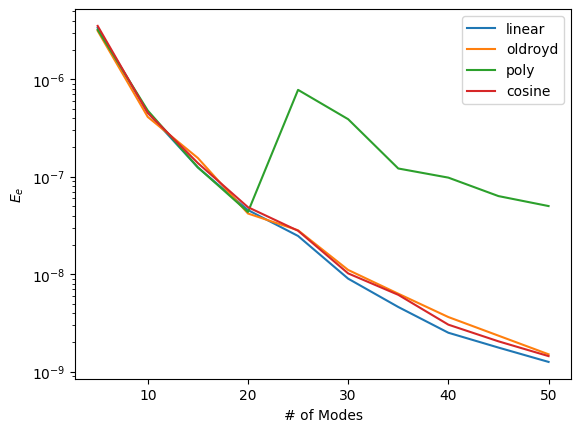

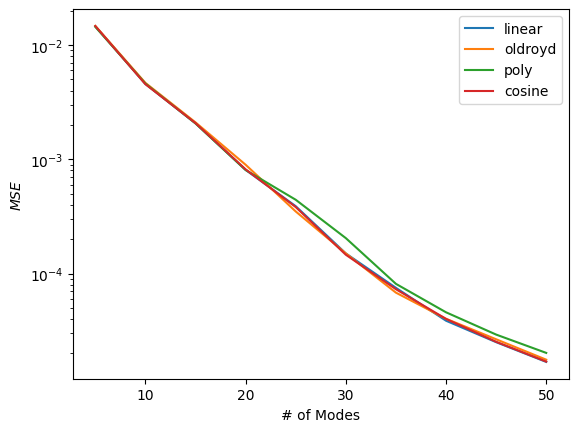

In [64]:
for i, k in enumerate(results):
    plt.plot(modes,k, label = kernels_type[i])
# plt.plot(modes,results_rbf, label = 'RBF')
plt.xlabel('# of Modes')
plt.ylabel('$E_e$')
plt.legend()
plt.yscale('log')

plt.figure()
for i, k in enumerate(results_mse):
    plt.plot(modes,k, label = kernels_type[i])
# plt.plot(modes,results_rbf, label = 'RBF')
plt.xlabel('# of Modes')
plt.ylabel('$MSE$')
plt.legend()
plt.yscale('log')

In [10]:
energies = []
mses = []
m = 2
for j,ker in enumerate(kernels):
        ker.train_R(n_components=m, degree=1)
        # ker.R[:,0] +=3.3/ker.R.shape[0]
        phi = ker.transform(X, theta, eps=2, dx=dx, dy = dy)

        X_rec = ker.invert_transform(phi, theta, eps = None)

        # 4- Calc error
        _, _, energy_rec = calc_energy(X_rec,Wi,beta, Re, dx, dy)
        energies.append(energy_rec)
        mses.append(np.linalg.norm(X - X_rec.T) / norm_mse)

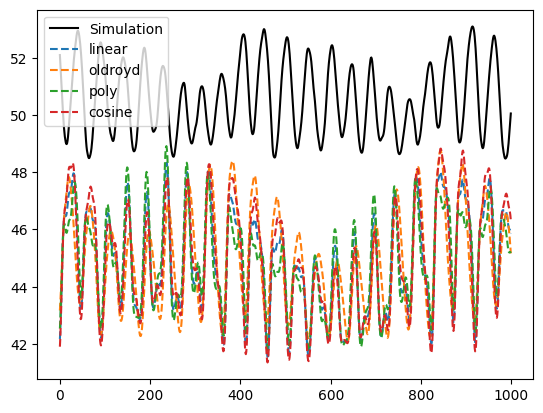

In [11]:
plt.plot(energy_X,'k', label = 'Simulation')
for k, e in zip(kernels_type, energies):
    # if k == 'oldroyd':
    #     plt.plot(e,'--', label = k)
    plt.plot(e,'--', label = k)
plt.legend()

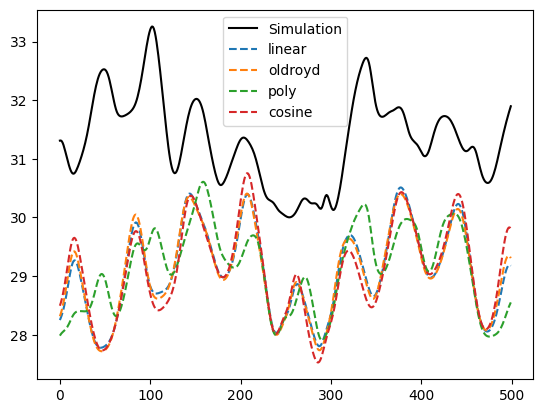

In [12]:
plt.plot(energy_X,'k', label = 'Simulation')
for k, e in zip(kernels_type, energies):
    # if k == 'oldroyd':
    #     plt.plot(e,'--', label = k)
    plt.plot(e,'--', label = k)
plt.legend()

<BarContainer object of 4 artists>

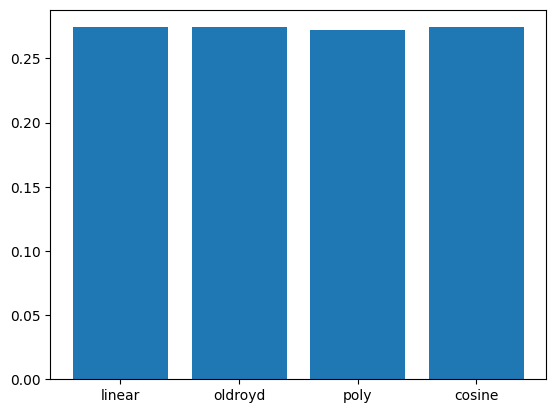

In [13]:
plt.bar(kernels_type,mses)

In [138]:
3.3/ker.R.shape[0]

0.00016113281249999998